# Data augmentation

Probando manera dinámica de generar el dataset, y que permita hacer más data augmentation de las imágenes para agrandar el dataset a demanda.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, MaxPooling2D, Input, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from glob import glob
import numpy as np
from numpy.linalg import inv
import os
import shutil
import random
import cv2
import gc
import matplotlib.pyplot as plt
import pandas as pd
from itertools import zip_longest
import uuid
from multiprocessing import Pool, cpu_count

%matplotlib inline

## División de train / validation

Dividimos el dataset de imágenes en dos conjuntos, uno de entrenamiento y otro de validación.

In [3]:
DATA_DIR = os.path.join('.')

In [4]:
X = glob(os.path.join(DATA_DIR, 'val2017', '*.jpg'))

In [6]:
len(X), X[0]

(5000, './val2017/000000099039.jpg')

In [7]:
def train_test_split(X, test_size=0.2):
    n_test = round(len(X) * test_size)
    random.shuffle(X)
    test_samples, train_samples = X[:n_test], X[n_test:]
    return train_samples, test_samples

In [8]:
X_train, X_val = train_test_split(X, test_size=0.2)
len(X_train), len(X_val)

(4000, 1000)

## Generación de imágenes

Primero definimos los siguientes parámetros:

In [9]:
WIDTH, HEIGHT = 320, 240
RHO = 32
PATCH_SIZE = 128

A continuación se define la función `process_image` que, dadda una imagen, extrae dos imágenes con un parche aleatorio, y su correspondiente vector 8x1 que representa la homografía que relaciona ambas imágenes.

In [10]:
def random_patch_positions():
    """Calculate random position for patch P"""
    px = random.randint(RHO, WIDTH - PATCH_SIZE - RHO)
    py = random.randint(RHO, HEIGHT - PATCH_SIZE - RHO)
    return px, py  

def random_delta():
    """Calculate random delta for patch corner distortion"""
    return np.random.randint(-RHO, RHO, size=2)

def extract_from_patch(img, patch):
    """Extract patch from image"""
    a, _, c, _ = patch
    return img[a[1]:c[1], a[0]:c[0]]

def build_random_patch():
    px, py = random_patch_positions()
    return [(px, py),
            (px + PATCH_SIZE, py),
            (px + PATCH_SIZE, py + PATCH_SIZE),
            (px, py + PATCH_SIZE)]

def distort_patch(patch):
    return [p + random_delta() for p in patch]


def warp_image(img, patch, new_patch):
    # Get homography matrix
    H = cv2.getPerspectiveTransform(
        np.float32(patch),
        np.float32(new_patch))
    
    # Transform image with H
    return cv2.warpPerspective(img, inv(H),
        (img.shape[1], img.shape[0]))  

def process_image(img, debug=False):
    # Resize and convert to grayscale
    resized_img = cv2.resize(img, (WIDTH, HEIGHT))
    if len(resized_img.shape) == 3:
        gray_img = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
    else:
        gray_img = resized_img
        
    assert(len(gray_img.shape) == 2)
 
    # Build patch, and perturb corners
    patch = build_random_patch()
    distorted_patch = distort_patch(patch)

    warped_img = warp_image(gray_img, patch, distorted_patch)
    
    # Extract patches
    a_img = extract_from_patch(gray_img, patch)
    b_img = extract_from_patch(warped_img, patch)
    
    # Stack patch images together
    x = np.dstack([a_img, b_img])
    
    # Subtract patches to get delta
    # int8 is good enough because RHO = 32, so, values are in [-32, 32] range
    y = np.subtract(patch, distorted_patch).ravel().astype(np.int8)

    if debug:
        # On debug mode, return also original patch and warped img for plotting
        return x, y, (patch, distorted_patch), (gray_img, warped_img)
    
    return x, y

Vamos a plotear y ver los resultados de la función para corroborar que funciona correctamente:

In [11]:
def plot_processed_image(img_path):
    img = plt.imread(img_path)
    x, y, patches, imgs = process_image(img, debug=True)
    
    print('Label: {}'.format(y))
    
    for i in range(2):
        plt.subplot(2, 2, i+1)
        plt.grid(False)    
        temp_img = cv2.cvtColor(imgs[i], cv2.COLOR_GRAY2RGB)
        cv2.polylines(temp_img, np.int32([patches[i]]), 1, (255, 0, 0), thickness=2)    
        plt.imshow(temp_img, cmap='gray')

    for i in range(2):
        patch_img = x[:, :, i]
        
        print('[{}] shape={}'.format(i, patch_img.shape))        
        print('[{}] mean={}, std={}'.format(
            i, np.mean(patch_img), np.std(patch_img)))
      
        plt.subplot(2, 2, i+3)
        plt.grid(False)
        plt.imshow(patch_img, cmap='gray')
        #plt.text(0.5,0.5, str((2, 2, i)), ha=’center’, fontsize = 10)
        plt.tight_layout()

Label: [ 20   2 -30 -23   6 -11   1  -9]
[0] shape=(128, 128)
[0] mean=109.933837890625, std=66.05940591528181
[1] shape=(128, 128)
[1] mean=113.77349853515625, std=62.05495574517512


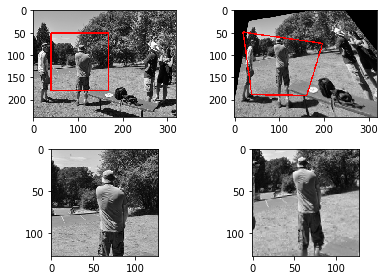

In [12]:
plot_processed_image(X_train[0])

Label: [ 15 -15 -19 -23  22 -20 -21   8]
[0] shape=(128, 128)
[0] mean=107.08929443359375, std=51.01050196941898
[1] shape=(128, 128)
[1] mean=106.76800537109375, std=57.1749138666612


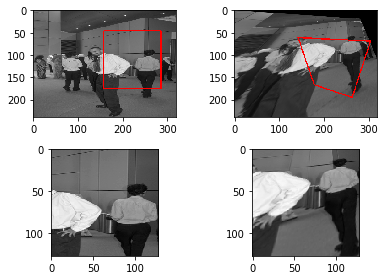

In [13]:
plot_processed_image(X_train[10])

In [14]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def generate_dataset_archives(dirname, n_jobs=cpu_count()):
    if os.path.exists(dirname):
        print('{} already exists! Delete it if you want to regenerate archives.'.format(dirname))
        return
    
    datasets = dict(train=X_train, val=X_val)

    for key, X_set in datasets.items():
        random.shuffle(X_set)
        
        for img_group in grouper(X_set, NUM_IMAGES_PER_ARCHIVE):
            xs, ys = [], []

            for img_path in img_group:
                if img_path:
                    for i in range(NUM_SAMPLES_PER_IMAGE):
                        img = plt.imread(img_path)
                        try:
                            x, y = process_image(img)
                        except:
                            print("Image broken? {}".format(img_path))
                            raise
                        xs.append(x)
                        ys.append(y)

            xs = np.array(xs, dtype=np.uint8)
            ys = np.array(ys, dtype=np.int8)
            
            outfile = os.path.join(dirname, key, '{}.npz'.format(uuid.uuid4()))
            os.makedirs(os.path.dirname(outfile), exist_ok=True)
            np.savez_compressed(outfile, x=xs, y=ys)
            print(outfile)

## *Data generators* y preprocesamiento

In [103]:
from imgaug import augmenters as iaa

# TODO Add more options
seq = iaa.Sequential([
    #iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

In [96]:
def preprocess_features(x):
    # Rescale and sample-wise centering
    x = (x - 127.5) / 127.5
    return x

def preprocess_labels(y):
    # Rescale
    y = y / RHO
    return y

def build_data_generator(imgpath, batch_size=64):
    imgfiles = glob(os.path.join(imgpath, '*.jpg'))
    
    if not imgfiles:
        return
    
    xs, ys = [], []
    while True:
        random.shuffle(imgfiles)
        
        for img_path in imgfiles:
            img = plt.imread(img_path)
            img = seq.augment_images([img])[0]

            try:
                x, y = process_image(img)
            except:
                print("Image broken? {}".format(img_path))
                raise
            xs.append(x)
            ys.append(y)

            # Yield minibatches
            if len(xs) == batch_size:
                xs = np.array(xs, dtype=np.uint8)
                ys = np.array(ys, dtype=np.int8)

                # Preprocess features and labels
                xs = preprocess_features(xs)
                ys = preprocess_labels(ys)

                yield xs, ys

                xs, ys = [], []

In [97]:
TRAIN_DIR = os.path.join(DATA_DIR, 'dataset', 'train')
VAL_DIR = os.path.join(DATA_DIR, 'dataset', 'val')

In [98]:
gen = build_data_generator('val2017')

In [99]:
xs, ys = next(gen)

In [100]:
len(xs), len(ys)

(64, 64)

In [101]:
xs[0].shape, ys[0].shape

((128, 128, 2), (8,))

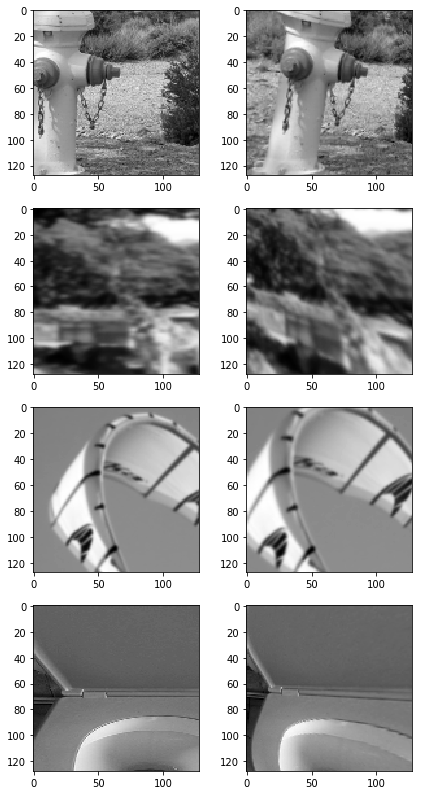

In [102]:
plt.figure(figsize=(7,7*2))

for i in range(4):
    img_a = xs[i][:, :, 0]
    plt.subplot(4, 2, (i*2)+1)
    plt.grid(False)
    plt.imshow(img_a, cmap='gray')
    #plt.tight_layout()
    
    img_b = xs[i][:, :, 1]
    plt.subplot(4, 2, (i*2)+2)
    plt.grid(False)
    plt.imshow(img_b, cmap='gray')
    #plt.tight_layout()    